In [1]:
%run DL_Lib.ipynb
%run DL_func.ipynb

The first step consists of generating the synthetic data. The data is generated from the graph shown belown. Z denotes the unobserved latent variables, Y is the target variable which will be assumed observed (i.e. in the cow/camel classification problem 'Y' will correspond to the label 'cow' / 'camel'). X is the observed features as is generated from Z via a neural network. In the cow / camel classification problem 'X' would correspond to the actual image. Finally, an environment variable E is introduced. The environment determines the mean of the gaussian distribution the Z's are drawn from. The generative process for each of the variables is as follows:

$$Z_1 = \mathcal{N}(E, \sigma=1)$$
$$Z_2 = \mathcal{N}(2E, \sigma=2)$$
$$Y = \mathcal{N}(\alpha_1 \cdot Z_1+\alpha_2 \cdot Z_2, \sigma=1)$$
$$Y = \mathcal{N}(\alpha_3 \cdot Y, \sigma=1)$$
$$X = g(Z_1, Z_2, Z_3)$$

Where g is a randomly initialized neural network. All of the alphas are in this case set to 1.

First off, the Y's and Z's are generated from 4 different environments. 1000 samples from each environment is drawn.

In [2]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [3]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Z3,Y,Env_mean,Env,c
0,3.66,6.46,10.25,9.89,3.0,2,green
1,0.25,-0.80,-1.37,-1.03,0.2,0,red
2,1.09,4.39,4.33,4.14,2.0,1,blue
3,3.36,10.04,14.06,13.49,3.0,2,green
4,3.99,12.99,15.80,17.19,5.0,3,yellow
...,...,...,...,...,...,...,...
3995,3.48,6.59,10.86,9.73,3.0,2,green
3996,3.38,12.37,14.90,15.41,5.0,3,yellow
3997,-0.31,1.26,0.48,0.20,0.2,0,red
3998,0.15,2.81,3.77,2.97,2.0,1,blue


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

In [4]:
# for creating a responsive plot
#%matplotlib qt
%matplotlib inline

plot_latent_3d(df, m)

<Figure size 640x480 with 0 Axes>

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [5]:
net=Net(3, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [6]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [7]:
net=UglyiVAE(x.float(), y.float(), e.float(), 15, 3, 3, 10, 5, 3, beta=1)

C:\Users\mathi\anaconda3\envs\DeepLearning\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [8]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(91.5721)
Epoch 40 of 200
Train loss: tensor(65.0319)
Epoch 60 of 200
Train loss: tensor(29.0608)
Epoch 80 of 200
Train loss: tensor(16.0910)
Epoch 100 of 200
Train loss: tensor(9.0013)
Epoch 120 of 200
Train loss: tensor(4.5750)
Epoch 140 of 200
Train loss: tensor(1.6970)
Epoch 160 of 200
Train loss: tensor(-0.0559)
Epoch 180 of 200
Train loss: tensor(-1.2221)
Epoch 200 of 200
Train loss: tensor(-2.0249)


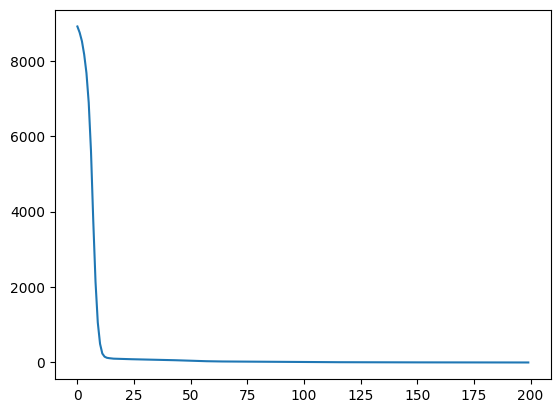

In [9]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [10]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 3))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [11]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Z3', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

In [12]:
#%matplotlib qt
#plot_latent_3d(df, m)

In [13]:
pdf=df[['Z1', 'Z2', 'Z3']]
pdf.columns = ['pZ1', 'pZ2', 'pZ3']
cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values
cdf['pZ3']=pdf['pZ3'].values

corrs=cdf.corr().iloc[:3,3:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs.max()).mean()
mcc, mcc_abs

(0.3785948450522583, 0.9136911311693806)

## Case with just 2 latent variables ##

In [14]:
E_choice, Env, Y, Z = generate_z_and_y(np.array([0.2, 2, 3, 5]), 4000, three_z=False)

Samples from the generative process is shown in the below dataframe along with markers of which environment a sample was drawn from and the corresponding 'mean' of that environment.

In [15]:
df=pd.concat([p(Z), p(Y), p(Env), p(E_choice)],axis=1)
df.columns = ['Z1', 'Z2', 'Y', 'Env_mean', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
tdf=df
df.round(2)

,Z1,Z2,Y,Env_mean,Env,c
0,3.69,5.42,9.64,2.0,1,blue
1,1.35,1.95,3.18,0.2,0,red
2,4.48,9.82,13.43,5.0,3,yellow
3,5.79,13.00,18.48,5.0,3,yellow
4,4.03,4.73,8.57,3.0,2,green
...,...,...,...,...,...,...
3995,0.67,5.29,5.89,2.0,1,blue
3996,1.82,9.56,10.48,3.0,2,green
3997,4.51,6.76,12.32,5.0,3,yellow
3998,6.46,9.44,16.05,5.0,3,yellow


Figure x shows a 3d-plot of the samples in (Z1, Z2, Z3)-space coloured by environment.

In [16]:
# for creating a responsive plot
#%matplotlib qt

#plot_latent_3d(df, m)

Finally, the observed X-values are generated via a randomly initialized neural network with 6 hidden units and 10 output units.

In [17]:
net=Net(2, 6, 10)
X=net(torch.from_numpy(Z.astype("float32"))).detach().numpy()

In [18]:
dset = EnvDataset(X[:2000],Y[:2000],E_choice[:2000])
train_loader = DataLoader(dset, batch_size=128, drop_last=True)
dset = EnvDataset(X[2000:],Y[2000:],E_choice[2000:])
test_loader = DataLoader(dset, batch_size=128, drop_last=True)
x,y,e = next(iter(train_loader))

In [19]:
net=UglyiVAE(x.float(), y.float(), e.float(), 15, 2, 2, 10, 5, 2, beta=1)

C:\Users\mathi\anaconda3\envs\DeepLearning\lib\site-packages\torch\distributions\distribution.py:44: UserWarning: <class '__main__.Normal_dist'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  warnings.warn(f'{self.__class__} does not define `arg_constraints`. ' +


In [20]:
from torch.optim import Adam
optimizer = Adam(net.parameters(), lr=1e-3)

epochs = 200
train_loss = torch.zeros(epochs)
elbo_loss = torch.zeros(epochs)
SM_loss = torch.zeros(epochs)
pz_ye_loss = torch.zeros(epochs)

for epoch in range(epochs):
    epoch_loss = 0
    if epoch < 20:
        beta = 10
    else:
        beta = 10
    for x,y,e in train_loader:
        optimizer.zero_grad()
        loss = net.elbo(x.float(), y.float(), e.float())
        loss.mul(-1).backward()
        optimizer.step()
        epoch_loss += loss.mul(-1).detach()
        
    if (epoch+1)%20 == 0:
        print('Epoch', epoch+1, 'of', epochs)
        print('Train loss:', epoch_loss/len(train_loader))
    train_loss[epoch] = epoch_loss/len(train_loader)

Epoch 20 of 200
Train loss: tensor(17.1297)
Epoch 40 of 200
Train loss: tensor(5.8677)
Epoch 60 of 200
Train loss: tensor(1.3867)
Epoch 80 of 200
Train loss: tensor(-1.1664)
Epoch 100 of 200
Train loss: tensor(-2.1109)
Epoch 120 of 200
Train loss: tensor(-2.6886)
Epoch 140 of 200
Train loss: tensor(-3.2841)
Epoch 160 of 200
Train loss: tensor(-3.8423)
Epoch 180 of 200
Train loss: tensor(-7.8875)
Epoch 200 of 200
Train loss: tensor(-8.5622)


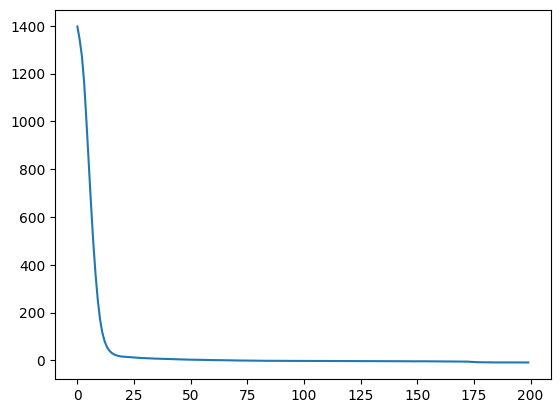

In [21]:
import matplotlib.pyplot as plt
plt.plot(train_loss)
plt.show()


In [22]:
# get z
loader = test_loader
latent_variables = torch.zeros((len(train_loader)*128, 2))
envs_samp = np.zeros((len(train_loader)*128, 4))
i = 0
for x,y,e in loader:
    _, _, _, _, _, z = net.forward(x.float(), y.float(), e.float(), beta=1)
    latent_variables[i*128:i*128+128,:] = z.detach()
    envs_samp[i*128:i*128+128,:] = e.squeeze().numpy().astype(int)
    i+=1

In [23]:
df=pd.concat([p(latent_variables.detach().numpy()), p(np.argmax(envs_samp, axis=1))],axis=1)
df.columns = ['Z1', 'Z2', 'Env']
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'yellow'}
m=df['Env'].map(colors)
df['c']=m
#df.round(2)

Text(0, 0.5, 'Z2-axis')

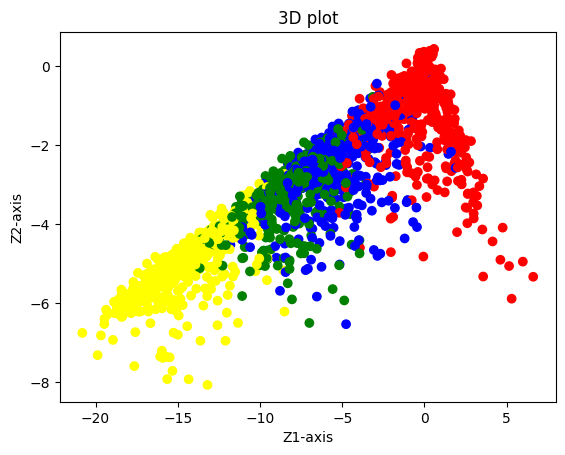

In [24]:
#%matplotlib qt
#plot_latent_3d(df, m)
fig = plt.figure()


# creating the plot
plt.scatter(df['Z1'], df['Z2'], c=m)
# setting title and labels
plt.title("3D plot")
plt.xlabel('Z1-axis')
plt.ylabel('Z2-axis')

In [25]:
pdf=df[['Z1', 'Z2']]
pdf.columns = ['pZ1', 'pZ2']
cdf=tdf[['Z1', 'Z2']].iloc[2000:3920,:]
#cdf=tdf[['Z1', 'Z2', 'Z3']].iloc[:1920,:]
cdf['pZ1']=pdf['pZ1'].values
cdf['pZ2']=pdf['pZ2'].values

corrs=cdf.corr().iloc[:2,2:]
mcc=corrs.max().mean()
mcc_abs=np.abs(corrs.max()).mean()
mcc, mcc_abs

(-0.8067424456839358, 0.8067424456839358)